In [94]:
import argparse
import string

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.autograd import Variable
from torch.optim import SGD
import torch.nn.functional as F

import pennylane as qml

In [95]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_size, context_size, hidden_size=512):
        super(CBOW, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.context_size = context_size
        self.hidden_size = hidden_size
        self.embeddings = nn.Embedding(self.vocab_size, self.embedding_size)
        # return vector size will be context_size*2*embedding_size
        self.lin1 = nn.Linear(self.context_size * 2 * self.embedding_size, self.hidden_size)
        self.lin2 = nn.Linear(self.hidden_size, self.vocab_size)
    
    def forward(self, inp):
        out = self.embeddings(inp).view(1, -1)
        out = out.view(1, -1)
        out = self.lin1(out)
        out = F.relu(out)
        out = self.lin2(out)
        out = F.log_softmax(out, dim=1)
        return out
    
    def get_word_vector(self, word_idx):
        word = Variable(torch.LongTensor([word_idx]))
        return self.embeddings(word).view(1, -1)

In [96]:
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

class QCBOW(nn.Module):
    def __init__(self, vocab_size, embedding_size, context_size, hidden_size=512, n_qlayers=2, n_qubits=8):
        super(QCBOW, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.context_size = context_size
        self.hidden_size = hidden_size
        self.embeddings = nn.Embedding(self.vocab_size, self.embedding_size)
        # dressed quantum layer
        self.lin1 = nn.Linear(self.context_size * 2 * self.embedding_size, n_qubits)
        self.weight_shapes = {"weights": (n_qlayers, n_qubits)}
        self.qlayer = qml.qnn.TorchLayer(qnode, self.weight_shapes)
        self.lin2 = nn.Linear(n_qubits, self.vocab_size)


    def forward(self, inp):
        out = self.embeddings(inp).view(1, -1)
        out = out.view(1, -1)
        out = self.lin1(out)
        out = F.relu(out)
        out = self.qlayer(out)
        out = self.lin2(out)
        out = F.log_softmax(out, dim=1)
        return out
    
    def get_word_vector(self, word_idx):
        word = Variable(torch.LongTensor([word_idx]))
        return self.embeddings(word).view(1, -1)

In [102]:
def train_cbow(cbow, data, unique_vocab, word_to_idx, n_epochs=20, lr=0.01):
    
    nll_loss = nn.NLLLoss()  # loss function
    optimizer = SGD(cbow.parameters(), lr=lr)
    
    print("Starting model training...")
    
    history = {
        'epoch': [],
        'loss': []
    }
    for iepoch in range(n_epochs):
        total_loss = 0
        for context, target in data:            
            inp_var = Variable(torch.LongTensor([word_to_idx[word] for word in context]))
            target_var = Variable(torch.LongTensor([word_to_idx[target]]))
                        
            cbow.zero_grad()
            log_prob = cbow(inp_var)
            loss = nll_loss(log_prob, target_var)
            loss.backward()
            optimizer.step()
            total_loss += loss.data
        
        loss_avg = float(total_loss / len(data))
        print("{}/{} loss {:.2f}".format(iepoch, n_epochs, loss_avg))
        history['loss'].append(loss_avg)
        history['epoch'].append(iepoch)
    return history

In [98]:
def test_cbow(cbow, unique_vocab, word_to_idx):
    # test word similarity
    word_1 = unique_vocab[2]
    word_2 = unique_vocab[3]
    
    word_1_vec = cbow.get_word_vector(word_to_idx[word_1])[0]
    word_2_vec = cbow.get_word_vector(word_to_idx[word_2])[0]
    
    word_similarity = (word_1_vec.dot(word_2_vec) / (torch.norm(word_1_vec) * torch.norm(word_2_vec))).data.numpy()
    print("Similarity between '{}' & '{}' : {:0.4f}".format(word_1, word_2, word_similarity))

In [99]:
corpus_text = "This tutorial will walk you through the key ideas of deep learning programming using Pytorch." \
              " Many of the concepts (such as the computation graph abstraction and autograd) " \
              "are not unique to Pytorch and are relevant to any deep learning tool kit out there."

In [103]:
def main(corpus_text, context_size, embed_dim, n_epochs=20, lr=0.01):
    # consider 2*context_size as context window where middle word as target
    corpus_text = corpus_text.split(' ')
    for i in range(len(corpus_text)):
        sentence = corpus_text[i]
        cleaned_sentence = sentence.translate(str.maketrans('', '', string.punctuation))
        cleaned_sentence = cleaned_sentence.lower()
        corpus_text[i] = cleaned_sentence
    unique_vocab = list(set(corpus_text))
    unique_vocab = sorted(unique_vocab)
    vocab_size = len(unique_vocab)
    print(f"There are {vocab_size} unique words in the vocabulary")
    # mapping to index
    word_to_idx = {w: i for i, w in enumerate(unique_vocab)}
    print(word_to_idx)

    data = list()
    for i in range(context_size, len(corpus_text) - context_size):
        data_context = list()
        for j in range(context_size):
            data_context.append(corpus_text[i - context_size + j])
        
        for j in range(1, context_size + 1):
            data_context.append(corpus_text[i + j])
        data_target = corpus_text[i]
        data.append((data_context, data_target))
 
    print("Some data: ",data[:3])

    train_data, test_data = train_test_split(data, test_size=0.3)
    print(f"Training set size: {len(train_data)}")
    print(f"Test set size: {len(test_data)}")
    # define and train model
    #cbow = CBOW(vocab_size, embed_dim, context_size)
    cbow = QCBOW(vocab_size, embed_dim, context_size, n_qlayers=2, n_qubits=4)
    history = train_cbow(cbow, train_data, unique_vocab, word_to_idx, n_epochs, lr)
    
    # get two words similarity
    test_cbow(cbow, unique_vocab, word_to_idx)
    
    return history

In [104]:
context_size = 3
embed_dim = 32
n_epochs = 20
lr = 0.1
history = main(corpus_text, context_size, embed_dim, n_epochs, lr=lr)

There are 34 unique words in the vocabulary
{'abstraction': 0, 'and': 1, 'any': 2, 'are': 3, 'as': 4, 'autograd': 5, 'computation': 6, 'concepts': 7, 'deep': 8, 'graph': 9, 'ideas': 10, 'key': 11, 'kit': 12, 'learning': 13, 'many': 14, 'not': 15, 'of': 16, 'out': 17, 'programming': 18, 'pytorch': 19, 'relevant': 20, 'such': 21, 'the': 22, 'there': 23, 'this': 24, 'through': 25, 'to': 26, 'tool': 27, 'tutorial': 28, 'unique': 29, 'using': 30, 'walk': 31, 'will': 32, 'you': 33}
Some data:  [(['this', 'tutorial', 'will', 'you', 'through', 'the'], 'walk'), (['tutorial', 'will', 'walk', 'through', 'the', 'key'], 'you'), (['will', 'walk', 'you', 'the', 'key', 'ideas'], 'through')]
Training set size: 25
Test set size: 12
Starting model training...
0/20 loss 3.58
1/20 loss 3.40
2/20 loss 3.31
3/20 loss 3.26
4/20 loss 3.21
5/20 loss 3.14
6/20 loss 3.15
7/20 loss 3.13
8/20 loss 3.17
9/20 loss 3.08
10/20 loss 3.01
11/20 loss 3.02
12/20 loss 2.92
13/20 loss 3.02
14/20 loss 2.93
15/20 loss 2.98
16/

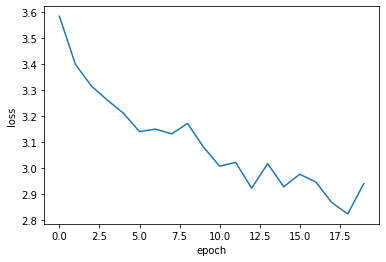

In [107]:
import seaborn as sns
sns.lineplot(data=history, x='epoch', y='loss')